# Goal & Setup

Using the emulator output in other notebooks, this code provides the user with an example of how uncertainties in LIG eustatic sea level measurements can influence future projections of sea level equivalent (SLE, in meters) mass loss from the total Antarctic ice-sheet.

The user inputs a sea-level measurement of eustatic sea level rise, the values assumed for the budgetary components of the eustatic SLR (the Greenland ice-sheet and thermosteric/mountain glacier contributions, see Dutton et al. 2015b, Science), and different elements of uncertainty (or the total uncertainty). Output are the resulting probablistic projected SL contributions from AIS in 2100 and 2150, and a visualization of how the individual mean LIG value and accompanying uncertainties affected the projections.

Note that the projections are based exclusively on a single ice-sheet model and an 196-member ensemble run over the LIG and an future climate scenario (RCP8.5). It is meant to be illustrative, and does not take into account structural or parameteric uncertainties in the ice-sheet model itself.

In [1]:
# import what we need for the code
import pandas as pd
import matplotlib.pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy
import math
from scipy.stats import norm

## User Inputs

All values are input in meters.

#### Greenland Ice sheet (GrIS, from Dutton et al. 2015a)

In [2]:
# Greenland Ice-sheet, in meters
GrIS={}
# From Dutton et al. (2015a) Science paper
GrIS['mean']=2.0
GrIS['uncertainty']=1.5

#### Thermosteric and mountain glacier components (from Dutton et al. 2015a)

In [3]:
TMG={}
TMG['mean']=1.0
TMG['uncertainty']=0.2

#### Survey Measurement & Error -- Field Data (e.g. Dutton et al. 2015a)

In [4]:
Field={}
Field['mean']=8.0
Field['uncertainty']=0.2

#### GIA Measurement (Multiple ESL Histories) & Error -- Field Data+GIA+Fingerprint (e.g. Dutton et al. 2015a, Dutton and Lambeck 2012, Hay et al. 2014)

In [5]:
GIA={}
GIA['mean']=7.6
GIA['uncertainty']=1.7

#### Dynamic Topography, Subsidence, GIA & Error -- Field Data+DT+Subsidence+GIA+Fingerprint (e.g. Dutton et al. 2015a, Austermann et al. 2017)

In [6]:
DT={}
DT['mean']=8.4
DT['uncertainty']=2.5

#### Configuration Offset -- Arbitrary and Scenario Dependant (Add an offset to the mean, e.g. if Laurentide was negative contribution)

The offset represents the amount of ice (in sea level equivalent) that may have been around in the early part of the LIG (e.g. the Laurentide ice-sheet). If the offset is positive, then the total sea level as measured will increase.

Note the default for the offset is Zero!

In [7]:
Offset=0.0

#### User Input -- Instead of a Documented example, the user can input their own numbers here

In [8]:
User={}
User['mean']=7.5
User['uncertainty']=0.5

### Load the Emulated Conditional Distributions and Weighting Grid

In [9]:
# load the probabilities
dat_in=pickle.load(open( "./models/conditional_data.pk1", "rb" ) )
dat_in.keys()

dict_keys(['posterior_2100', 'conditional_dat', 'step_locs_2150', 'step_locs_2100', 'posterior_2150'])

In [10]:
# load the prior
lig_emulator_dat=pickle.load(open( "./models/lig_posteriors.pk1", "rb" ) )
dat_lig_weightings=lig_emulator_dat['ligmid_weightings']
lig_emulator_dat.keys()

dict_keys(['ligmid_weightings', 'lig_posteriors', 'idealized_mid_steps'])

# Load/Create Support Modules

In [11]:
from lig_utilities import find_quantile_ts, find_quantile_i

## Module: Calculate PDFs as a function of the distribution chosen and Prior

In [12]:
def calculate_pdfs(dat_in,AIS,dat_lig_weightings):

    # define the central bins that we will explore the uncertainty around with this method
    central_bins=dat_in['conditional_dat']['idealized_mid_steps']
    central_i=np.arange(len(dat_in['conditional_dat']['idealized_mid_steps']))
    # define the uncertainty ranges that will define the area we search
    uncertainty_ranges=np.linspace(0.05,3,60)
    uncertainty_i=np.arange(len(uncertainty_ranges))

    # define the quantiles we want
    qb=np.asarray([2.5,97.5],dtype='int')
    # create the array we need to store the data
    quants_b=np.empty((len(central_bins),len(uncertainty_ranges),len(qb)),dtype='float64')

    # loop over the bins and find the quantile ranges in RCP8.5 associated with each
    for b in range(len(central_bins)):

        # loop over the uncertainty ranges
        for r in range(len(uncertainty_ranges)):

            # find the bins to integrate over
            low_bound,up_bound=central_i[b]-uncertainty_i[r],central_i[b]+uncertainty_i[r]
            if low_bound<0:
                low_bound=0
            if up_bound>len(dat_in['conditional_dat']['idealized_mid_steps']):
                up_bound=len(dat_in['conditional_dat']['idealized_mid_steps'])

            # find the integrated densitities over the bins in question, weight by the LIG prior
            integrated_pdf=np.sum(dat_in['posterior_2100'][low_bound:up_bound,:]*dat_lig_weightings['posterior'][low_bound:up_bound,:],axis=0)
            norm_pdf=integrated_pdf/np.sum(integrated_pdf)

            if math.isnan(norm_pdf[0]):
                quants_get=0
                quants_b[b,r,:]=0

            else:

                quants_get=find_quantile_ts(np.cumsum(norm_pdf).reshape(len(dat_in['step_locs_2100']),1),qb,dat_in['step_locs_2100'],[0])
                quants_b[b,r,:]=np.squeeze(quants_get)

            # reset
            del quants_get, integrated_pdf, up_bound, low_bound

    # get the full distribution as a function of the input uncertainties
    low_bound_AIS = np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean']-AIS['uncertainty'],decimals=1)).argmin()
    up_bound_AIS = np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean']+AIS['uncertainty'],decimals=1)).argmin()
    if low_bound_AIS<0:
        low_bound_AIS=0
    if up_bound_AIS>len(dat_in['conditional_dat']['idealized_mid_steps']):
            up_bound_AIS=len(dat_in['conditional_dat']['idealized_mid_steps'])
            
    print(dat_in['posterior_2100'].shape)

    integrated_pdf_2100=np.sum(dat_in['posterior_2100'][low_bound_AIS:up_bound_AIS,:]*dat_lig_weightings['posterior'][low_bound_AIS:up_bound_AIS,:],axis=0)
    norm_pdf_2100=integrated_pdf_2100/np.sum(integrated_pdf_2100)
    
    integrated_pdf_2150=np.sum(dat_in['posterior_2150'][low_bound_AIS:up_bound_AIS,:]*dat_lig_weightings['posterior'][low_bound_AIS:up_bound_AIS,:],axis=0)
    norm_pdf_2150=integrated_pdf_2150/np.sum(integrated_pdf_2150)
    
    dat_out={'quants':quants_b,'pdf2100':norm_pdf_2100,'pdf2150':norm_pdf_2150}
    return(dat_out)

In [13]:
def calculate_pdfs_gaussian(dat_in,AIS,dat_lig_weightings):

    # define the central bins that we will explore the uncertainty around with this method
    central_bins=dat_in['conditional_dat']['idealized_mid_steps']
    central_i=np.arange(len(dat_in['conditional_dat']['idealized_mid_steps']))
    # define the uncertainty ranges that will define the area we search
    uncertainty_ranges=np.linspace(0.1,3,30)
    uncertainty_i=np.arange(len(uncertainty_ranges))
    
    # define the range of our weighting (identical to our bins)
    xlig=central_bins
    lig_pdf=norm(AIS['mean'],scale=AIS['uncertainty'])
    discrete_lig=lig_pdf.pdf(xlig)/np.sum(lig_pdf.pdf(xlig))
    AIS['weightings']=(discrete_lig).reshape(len(discrete_lig),1)

    # define the quantiles we want
    qb=np.asarray([2.5,97.5],dtype='int')
    # create the array we need to store the data
    quants_b=np.empty((len(central_bins),len(uncertainty_ranges),len(qb)),dtype='float64')

    # loop over the bins and find the quantile ranges in RCP8.5 associated with each
    for b in range(len(central_bins)):

        # loop over the uncertainty ranges
        for r in range(len(uncertainty_ranges)):
            
            # find the pdf to weight the solutions
            lig_pdf_obj=norm(central_bins[b],scale=uncertainty_ranges[r])
            discrete_pdf=(lig_pdf_obj.pdf(xlig)/np.sum(lig_pdf_obj.pdf(xlig))).reshape(len(xlig),1)
            #plt.plot(xlig,discrete_pdf)

            # find the integrated densitities over the bins in question, weight by the LIG prior
            integrated_pdf=np.sum(dat_in['posterior_2100']*dat_lig_weightings['posterior']*discrete_pdf,axis=0)
            norm_pdf=integrated_pdf/np.sum(integrated_pdf)

            if math.isnan(norm_pdf[0]):
                quants_get=0
                quants_b[b,r,:]=0

            else:

                quants_get=find_quantile_ts(np.cumsum(norm_pdf).reshape(len(dat_in['step_locs_2100']),1),qb,dat_in['step_locs_2100'],[0])
                quants_b[b,r,:]=np.squeeze(quants_get)

            # reset
            del quants_get, integrated_pdf, lig_pdf_obj, discrete_pdf 

    # get the full distribution as a function of the input uncertainties
    low_bound_AIS = np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean']-AIS['uncertainty'],decimals=1)).argmin()
    up_bound_AIS = np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean']+AIS['uncertainty'],decimals=1)).argmin()
    if low_bound_AIS<0:
        low_bound_AIS=0
    if up_bound_AIS>len(dat_in['conditional_dat']['idealized_mid_steps']):
            up_bound_AIS=len(dat_in['conditional_dat']['idealized_mid_steps'])

    integrated_pdf_2100=np.sum(dat_in['posterior_2100'][:,:]*dat_lig_weightings['posterior'][:,:]*AIS['weightings'],axis=0)
    norm_pdf_2100=integrated_pdf_2100/np.sum(integrated_pdf_2100)
    
    integrated_pdf_2150=np.sum(dat_in['posterior_2150'][:,:]*dat_lig_weightings['posterior'][:,:]*AIS['weightings'],axis=0)
    norm_pdf_2150=integrated_pdf_2150/np.sum(integrated_pdf_2150)
    
    dat_out={'quants':quants_b,'pdf2100':norm_pdf_2100,'pdf2150':norm_pdf_2150}
    return(dat_out)

# Find the Impact of a Specific Constraint Distribution

### Choose a Scenario, Calculate AIS contributions

In [14]:
# the user chooses a scenario for calculations
Scen=Field

In [15]:
# Uncertainties are added with the root-sum-square method
AIS={}
AIS['mean']=(Scen['mean']+Offset)-GrIS['mean']-TMG['mean']
AIS['uncertainty']=math.sqrt((Scen['uncertainty'])**2+(GrIS['uncertainty'])**2+(TMG['uncertainty'])**2)
AIS

{'mean': 5.0, 'uncertainty': 1.5264337522473748}

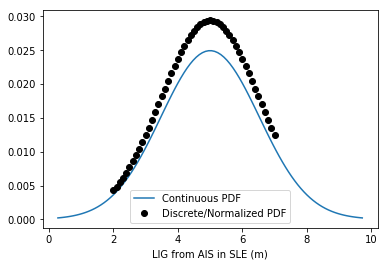

In [16]:
# get the continuous pdf of the central estimate and uncertainty (Gaussian noise)
lig_pdf=norm(AIS['mean'],scale=AIS['uncertainty'])
xlig=np.linspace(lig_pdf.ppf(0.001),lig_pdf.ppf(0.999), 100)
# get the normalized and discrete PDF at our steps
steps_xlig=dat_in['conditional_dat']['idealized_mid_steps']
discrete_lig=lig_pdf.pdf(steps_xlig)/np.sum(lig_pdf.pdf(steps_xlig))
# plot the result
plt.figure()
plt.plot(xlig,lig_pdf.pdf(xlig)/np.sum(lig_pdf.pdf(xlig)),label='Continuous PDF')
plt.plot(steps_xlig,discrete_lig,'ko',label='Discrete/Normalized PDF')
plt.xlabel('LIG from AIS in SLE (m)')
plt.legend()
plt.show()

In [17]:
# define the weightings
AIS['weightings']=(dat_lig_weightings['posterior']).reshape(len(dat_lig_weightings['posterior']),1)
Field['weightings']=(dat_lig_weightings['posterior']).reshape(len(dat_lig_weightings['posterior']),1)
GIA['weightings']=(dat_lig_weightings['posterior']).reshape(len(dat_lig_weightings['posterior']),1)
DT['weightings']=(dat_lig_weightings['posterior']).reshape(len(dat_lig_weightings['posterior']),1)

In [18]:
# calculate, using the module
scen_out=calculate_pdfs_gaussian(dat_in,AIS,dat_lig_weightings)

### Visualize the Associated PDF

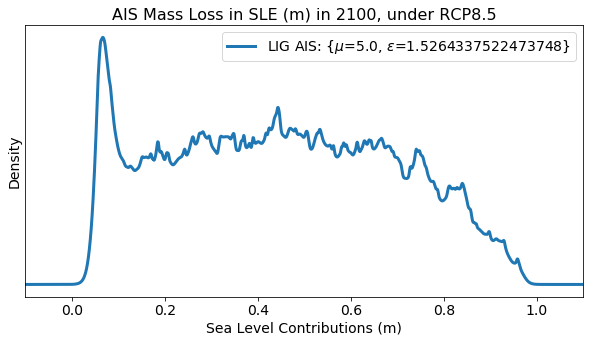

In [19]:
plt.figure(figsize=(10,5))
plt.plot(dat_in['step_locs_2100'],scen_out['pdf2100'],lw=3,label='LIG AIS: {$\mu$='+str(AIS['mean'])+', $\epsilon$='+str(AIS['uncertainty'])+'}')
plt.xlim([-0.1,1.1])
plt.title('AIS Mass Loss in SLE (m) in 2100, under RCP8.5',fontsize=16)
plt.ylabel('Density',fontsize=14)
plt.xlabel('Sea Level Contributions (m)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([],fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Plot the range of the future projection uncertainty as a function of the LIG uncertainty

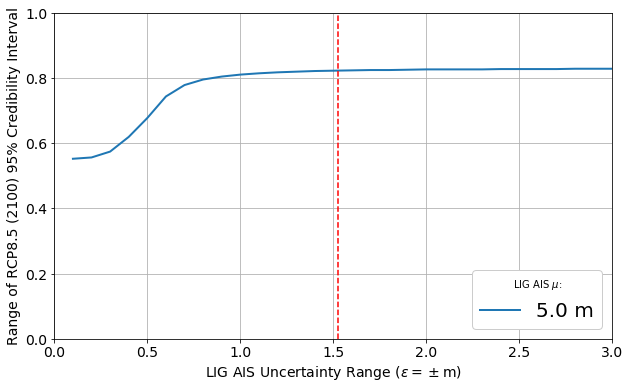

In [20]:
f=plt.figure(figsize=(10,6))
# find the bin of the central uncertainty
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_out['quants'][idx,:,1]-scen_out['quants'][idx,:,0])[:],label=str(np.round(AIS['mean'],decimals=1))+' m',lw=2)
plt.axvline(x=AIS['uncertainty'],color='r',linestyle='--')
plt.grid()
plt.ylim([0,1.0])
plt.xlim([0,3.0])
plt.xlabel('LIG AIS Uncertainty Range ($\epsilon = \pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Credibility Interval',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=20,title='LIG AIS $\mu$:',framealpha=1.0)
plt.show()

# Composite Figure 8A - Field

In [21]:
# the user chooses a scenario for calculations
Scen=Field
AIS,AIS_noGrISerror={},{}
AIS['mean']=(Scen['mean']+Offset)-GrIS['mean']-TMG['mean']
AIS['uncertainty']=math.sqrt((Scen['uncertainty'])**2+(GrIS['uncertainty'])**2+(TMG['uncertainty'])**2)
AIS_noGrISerror['mean']=AIS['mean']
AIS_noGrISerror['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
print(AIS)
print(AIS_noGrISerror)

{'uncertainty': 1.5264337522473748, 'mean': 5.0}
{'uncertainty': 0.2, 'mean': 5.0}


In [22]:
# get the analysis
scen_A=calculate_pdfs_gaussian(dat_in,AIS,dat_lig_weightings)
scen_A_noGrISerror=calculate_pdfs_gaussian(dat_in,AIS_noGrISerror,dat_lig_weightings)

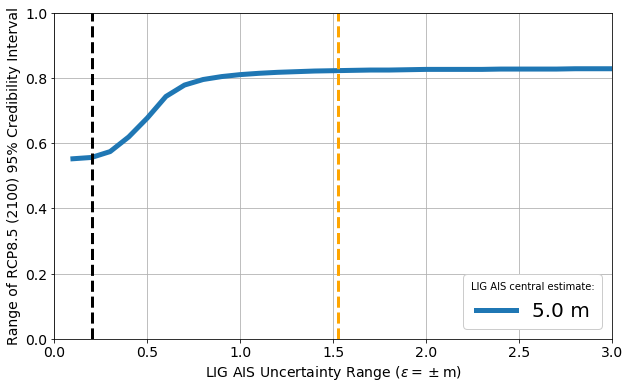

In [23]:
fA=plt.figure(figsize=(10,6))
# find the bin of the central uncertainty
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_A['quants'][idx,:,1]-scen_A['quants'][idx,:,0])[:],label=str(np.round(AIS['mean'],decimals=1))+' m',lw=5)
plt.axvline(x=AIS['uncertainty'],color='orange',linestyle='--',lw=3)
plt.axvline(x=AIS_noGrISerror['uncertainty'],color='k',linestyle='--',lw=3)
plt.grid()
plt.ylim([0,1.0])
plt.xlim([0,3.0])
plt.xlabel('LIG AIS Uncertainty Range ($\epsilon = \pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Credibility Interval',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=20,title='LIG AIS central estimate:',framealpha=1.0)
plt.show()

In [24]:
fA.savefig("figures/Fig8A.svg")

# Composite Figure 8B - GIA

In [25]:
# the user chooses a scenario for calculations
Scen=GIA
AIS,AIS_noGrISerror={},{}
AIS['mean']=(Scen['mean']+Offset)-GrIS['mean']-TMG['mean']
AIS['uncertainty']=math.sqrt((Scen['uncertainty'])**2+(GrIS['uncertainty'])**2+(TMG['uncertainty'])**2)
AIS_noGrISerror['mean']=AIS['mean']
AIS_noGrISerror['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
AIS['weightings']=(dat_lig_weightings['posterior']).reshape(len(dat_lig_weightings['posterior']),1)
print(AIS)
print(AIS_noGrISerror)

{'weightings': array([[  3.79250161e-33],
       [  3.24821795e-29],
       [  1.53666918e-25],
       [  4.04117193e-22],
       [  5.91755378e-19],
       [  4.80431822e-16],
       [  2.14456896e-13],
       [  5.21675705e-11],
       [  6.87035548e-09],
       [  4.88608945e-07],
       [  1.88367862e-05],
       [  3.99905541e-04],
       [  4.83068878e-03],
       [  3.46128313e-02],
       [  1.47462478e-01],
       [  3.70713437e-01],
       [  5.58171610e-01],
       [  5.11637795e-01],
       [  4.39759813e-01],
       [  5.18398940e-01],
       [  7.10372908e-01],
       [  7.94530686e-01],
       [  5.75621322e-01],
       [  3.01583205e-01],
       [  1.92484417e-01],
       [  1.76679258e-01],
       [  1.66114056e-01],
       [  1.46615960e-01],
       [  1.41874688e-01],
       [  1.58563692e-01],
       [  2.18522447e-01],
       [  3.33132778e-01],
       [  4.89947359e-01],
       [  5.22750059e-01],
       [  3.96818284e-01],
       [  2.44969073e-01],
       [  1.5

In [26]:
# get the analysis
scen_B=calculate_pdfs_gaussian(dat_in,AIS,dat_lig_weightings)
scen_B_noGrISerror=calculate_pdfs_gaussian(dat_in,AIS_noGrISerror,dat_lig_weightings)

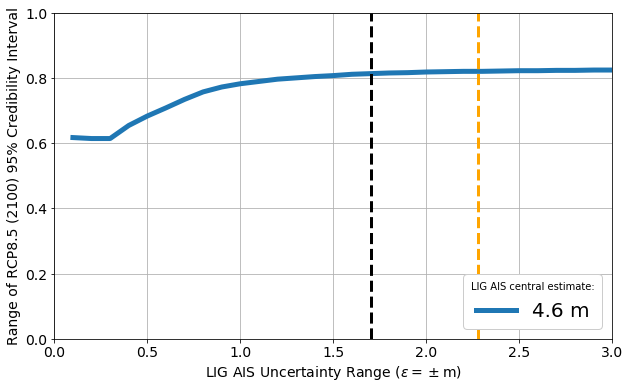

In [27]:
fB=plt.figure(figsize=(10,6))
# find the bin of the central uncertainty
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_B['quants'][idx,:,1]-scen_B['quants'][idx,:,0])[:],label=str(np.round(AIS['mean'],decimals=1))+' m',lw=5)
plt.axvline(x=AIS['uncertainty'],color='orange',linestyle='--',lw=3)
plt.axvline(x=AIS_noGrISerror['uncertainty'],color='k',linestyle='--',lw=3)
plt.grid()
plt.ylim([0,1.0])
plt.xlim([0,3.0])
plt.xlabel('LIG AIS Uncertainty Range ($\epsilon = \pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Credibility Interval',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=20,title='LIG AIS central estimate:',framealpha=1.0)
plt.show()

In [28]:
fB.savefig("figures/Fig8B.svg")

# Composite Figure 8C - DT

In [29]:
# the user chooses a scenario for calculations
Scen=DT
AIS,AIS_noGrISerror={},{}
AIS['mean']=(Scen['mean']+Offset)-GrIS['mean']-TMG['mean']
AIS['uncertainty']=math.sqrt((Scen['uncertainty'])**2+(GrIS['uncertainty'])**2+(TMG['uncertainty'])**2)
AIS_noGrISerror['mean']=AIS['mean']
AIS_noGrISerror['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
print(AIS)
print(AIS_noGrISerror)

{'uncertainty': 2.9223278392404914, 'mean': 5.4}
{'uncertainty': 2.5, 'mean': 5.4}


In [30]:
# get the analysis
scen_C=calculate_pdfs_gaussian(dat_in,AIS,dat_lig_weightings)
scen_C_noGrISerror=calculate_pdfs_gaussian(dat_in,AIS_noGrISerror,dat_lig_weightings)

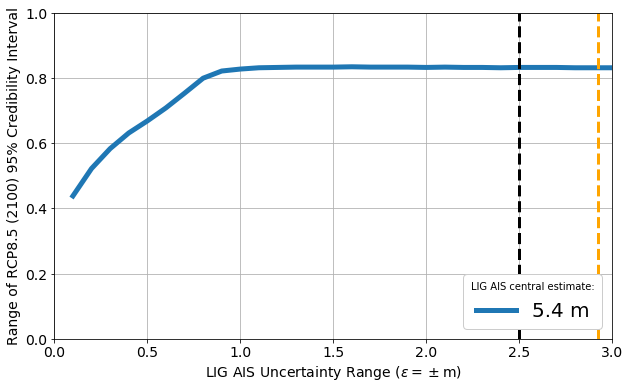

In [31]:
fC=plt.figure(figsize=(10,6))
# find the bin of the central uncertainty
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_C['quants'][idx,:,1]-scen_C['quants'][idx,:,0])[:],label=str(np.round(AIS['mean'],decimals=1))+' m',lw=5)
plt.axvline(x=AIS['uncertainty'],color='orange',linestyle='--',lw=3)
plt.axvline(x=AIS_noGrISerror['uncertainty'],color='k',linestyle='--',lw=3)
plt.grid()
plt.ylim([0,1.0])
plt.xlim([0,3.0])
plt.xlabel('LIG AIS Uncertainty Range ($\epsilon = \pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Credibility Interval',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right',fontsize=20,title='LIG AIS central estimate:',framealpha=1.0)
plt.show()

In [32]:
fC.savefig("figures/Fig8C.svg")

# Composite Figure 8D - PDF in 2100 with 0.5m uncertainty

In [33]:
# the user chooses a scenario for calculations
Scen=User
AIS_User_GrIS_0,AIS_User_GrIS_1,AIS_User_GrIS_2,AIS_User_GrIS_3,AIS_User_GrIS_4={},{},{},{},{}
AIS_User_GrIS_0['mean']=(Scen['mean']+Offset)-0.0-TMG['mean']
AIS_User_GrIS_1['mean']=(Scen['mean']+Offset)-1.0-TMG['mean']
AIS_User_GrIS_2['mean']=(Scen['mean']+Offset)-2.0-TMG['mean']
AIS_User_GrIS_3['mean']=(Scen['mean']+Offset)-3.0-TMG['mean']
AIS_User_GrIS_4['mean']=(Scen['mean']+Offset)-4.0-TMG['mean']
AIS_User_GrIS_0['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
AIS_User_GrIS_1['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
AIS_User_GrIS_2['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
AIS_User_GrIS_3['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
AIS_User_GrIS_4['uncertainty']=math.sqrt((Scen['uncertainty'])**2)
print(AIS_User_GrIS_1)

{'uncertainty': 0.5, 'mean': 5.5}


In [34]:
# get the analysis
scen_User_GrIS_0=calculate_pdfs_gaussian(dat_in,AIS_User_GrIS_0,dat_lig_weightings)
scen_User_GrIS_1=calculate_pdfs_gaussian(dat_in,AIS_User_GrIS_1,dat_lig_weightings)
scen_User_GrIS_2=calculate_pdfs_gaussian(dat_in,AIS_User_GrIS_2,dat_lig_weightings)
scen_User_GrIS_3=calculate_pdfs_gaussian(dat_in,AIS_User_GrIS_3,dat_lig_weightings)
scen_User_GrIS_4=calculate_pdfs_gaussian(dat_in,AIS_User_GrIS_4,dat_lig_weightings)

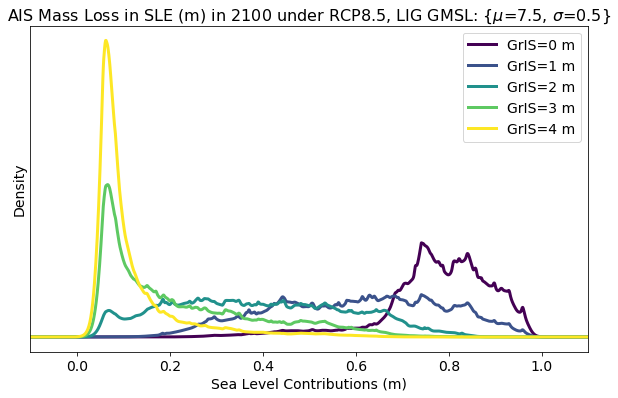

In [35]:
fD=plt.figure(figsize=(10,6))
plt.plot(dat_in['step_locs_2100'],scen_User_GrIS_0['pdf2100'],lw=3,label='GrIS=0 m',color=pl.cm.viridis(0.0))
plt.plot(dat_in['step_locs_2100'],scen_User_GrIS_1['pdf2100'],lw=3,label='GrIS=1 m',color=pl.cm.viridis(0.25))
plt.plot(dat_in['step_locs_2100'],scen_User_GrIS_2['pdf2100'],lw=3,label='GrIS=2 m',color=pl.cm.viridis(0.5))
plt.plot(dat_in['step_locs_2100'],scen_User_GrIS_3['pdf2100'],lw=3,label='GrIS=3 m',color=pl.cm.viridis(0.75))
plt.plot(dat_in['step_locs_2100'],scen_User_GrIS_4['pdf2100'],lw=3,label='GrIS=4 m',color=pl.cm.viridis(1.0))
plt.xlim([-0.1,1.1])
plt.title('AIS Mass Loss in SLE (m) in 2100 under RCP8.5, '+'LIG GMSL: {$\mu$='+str(User['mean'])+', $\sigma$='+str(User['uncertainty'])+'}',fontsize=16)
plt.ylabel('Density',fontsize=14)
plt.xlabel('Sea Level Contributions (m)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([],fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [36]:
fD.savefig("figures/Fig8D.svg")

## Example Figure with all central estimates, typical GrIS+TMG and Gaussian uncertianties

In [37]:
# the user chooses a scenario for calculations
AIS3,AIS4,AIS5,AIS6={},{},{},{}
AIS35,AIS45,AIS55,AIS65={},{},{},{}
AIS3['mean'],AIS4['mean'],AIS5['mean'],AIS6['mean']=3,4,5,6
AIS35['mean'],AIS45['mean'],AIS55['mean'],AIS65['mean']=3.5,4.5,5.5,6.5
AIS3['uncertainty'],AIS4['uncertainty'],AIS5['uncertainty'],AIS6['uncertainty']=1,1,1,1
AIS35['uncertainty'],AIS45['uncertainty'],AIS55['uncertainty'],AIS65['uncertainty']=1,1,1,1

In [38]:
scen_gen3=calculate_pdfs_gaussian(dat_in,AIS3,dat_lig_weightings)
scen_gen4=calculate_pdfs_gaussian(dat_in,AIS4,dat_lig_weightings)
scen_gen5=calculate_pdfs_gaussian(dat_in,AIS5,dat_lig_weightings)
scen_gen6=calculate_pdfs_gaussian(dat_in,AIS6,dat_lig_weightings)

scen_gen35=calculate_pdfs_gaussian(dat_in,AIS35,dat_lig_weightings)
scen_gen45=calculate_pdfs_gaussian(dat_in,AIS45,dat_lig_weightings)
scen_gen55=calculate_pdfs_gaussian(dat_in,AIS55,dat_lig_weightings)
scen_gen65=calculate_pdfs_gaussian(dat_in,AIS65,dat_lig_weightings)

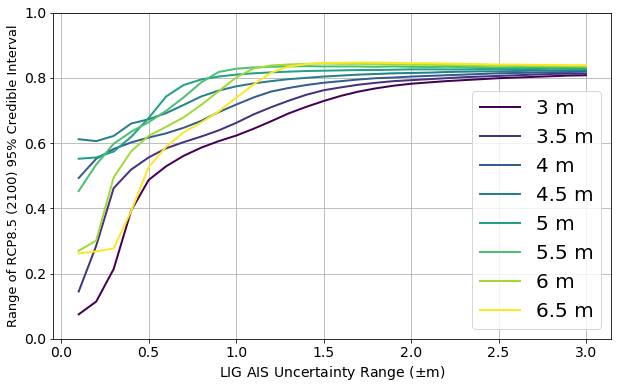

In [39]:
colors = pl.cm.viridis(np.linspace(0,1,len(dat_in['conditional_dat']['idealized_mid_steps'][0::5])-4))
f_all=plt.figure(figsize=(10,6))

# 3 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS3['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen3['quants'][idx,:,1]-scen_gen3['quants'][idx,:,0]),label='3 m',color=pl.cm.viridis(0.0),lw=2)

# 3.5 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS35['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen35['quants'][idx,:,1]-scen_gen35['quants'][idx,:,0]),label='3.5 m',color=pl.cm.viridis(1/7),lw=2)

# 4 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS4['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen4['quants'][idx,:,1]-scen_gen4['quants'][idx,:,0]),label='4 m',color=pl.cm.viridis(2/7),lw=2)

# 4.5 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS45['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen45['quants'][idx,:,1]-scen_gen45['quants'][idx,:,0]),label='4.5 m',color=pl.cm.viridis(3/7),lw=2)

# 5 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS5['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen5['quants'][idx,:,1]-scen_gen5['quants'][idx,:,0]),label='5 m',color=pl.cm.viridis(4/7),lw=2)

# 5.5 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS55['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen55['quants'][idx,:,1]-scen_gen55['quants'][idx,:,0]),label='5.5 m',color=pl.cm.viridis(5/7),lw=2)

# 6 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS6['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen6['quants'][idx,:,1]-scen_gen6['quants'][idx,:,0]),label='6 m',color=pl.cm.viridis(6/7),lw=2)

# 6.5 m
idx=np.abs(dat_in['conditional_dat']['idealized_mid_steps'] - np.round(AIS65['mean'],decimals=1)).argmin()
plt.plot(np.linspace(0.1,3,30)[:],(scen_gen65['quants'][idx,:,1]-scen_gen65['quants'][idx,:,0]),label='6.5 m',color=pl.cm.viridis(1.0),lw=2)

plt.grid()
plt.ylim([0,1.0])
plt.xlabel('LIG AIS Uncertainty Range ($\pm$m)',fontsize=14)
plt.ylabel('Range of RCP8.5 (2100) 95% Credible Interval',fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=20)
plt.show()

# Going Further: Calculate the PDFs associated with Narrower-D20

We want to calculate the PDFs associated with narrowing the D20-U LIG constraint by various percentages, which is a sensitivity test on how the LIG constraints could be improving future projections if this particular constraint was narrowed. It follows on the analysis above, but show particular PDFs associated with particular constraints (rather than above, which is more generalized).

#### Import KDE smoothing for comparison with Figures 6a-b

In [40]:
# define a function which resamples and properly scales the PDFs in prep. for KDE
def rescale_pdf_for_kde(step_locs,pdf_in):
    
    # import the packages we need
    import numpy as np
    
    # scale the PDF so that all values are whole numbers
    wholenum_pdf=np.round(pdf_in*10000,decimals=0)
    
    # set missing values in the whole number pdf to zero
    wholenum_pdf[np.isnan(wholenum_pdf)]=0
    
    # count the number of scaled samples we will work with, should be ~10k
    # note that the actual number of samples used to construct this distribution
    # was identically the size of the lhd
    n_kde=int(np.nansum(wholenum_pdf))
    
    # find the rescaled PDF on the same scale as the original data (known from step_locs)
    rescaled_pdf=np.empty((n_kde,),dtype='float')
    endpoint=0
    # loop over the bins
    for s in range(len(step_locs)):
        # get the count in this bin
        n_gt_zero=np.int(wholenum_pdf[s])
        # fill the bin counts with the the number in this bin, assigned the value of the bin
        if n_gt_zero>0:
            rescaled_pdf[endpoint:n_gt_zero+endpoint]=np.ones((n_gt_zero,),dtype='float')*step_locs[s]
            # update the index in the rescaled pdf vector
            endpoint=n_gt_zero+endpoint
    
    # go back to the above program level
    return(rescaled_pdf)

### Define the full suite of LIG constraints we could consider with our simple approach here

In [41]:
base_range=1.5
# prior
AIS_prior=AIS
AIS_prior['mean']=4.7
AIS_prior['uncertainty']=100
prior_out=calculate_pdfs(dat_in,AIS_prior,dat_lig_weightings)

# d19
AIS_d19=AIS
AIS_d19['mean']=4.6
AIS_d19['uncertainty']=base_range
d19_out=calculate_pdfs(dat_in,AIS_d19,dat_lig_weightings)

# reduced by 33%
AIS_red=AIS
AIS_red['mean']=4.6
AIS_red['uncertainty']=base_range*(2./3.)
red_out=calculate_pdfs(dat_in,AIS_red,dat_lig_weightings)

# lower margin
AIS_lower=AIS
AIS_lower['mean']=2.75
AIS_lower['uncertainty']=0.75
lower_out=calculate_pdfs(dat_in,AIS_lower,dat_lig_weightings)

# upper margin
AIS_upper=AIS
AIS_upper['mean']=6.5
AIS_upper['uncertainty']=0.5
upper_out=calculate_pdfs(dat_in,AIS_upper,dat_lig_weightings)

# Improved by 10%
AIS_range10=AIS
AIS_range10['mean']=4.6
AIS_range10['uncertainty']=base_range*0.9
range10_out=calculate_pdfs(dat_in,AIS_range10,dat_lig_weightings)

# Improved by 25%
AIS_range25=AIS
AIS_range25['mean']=4.6
AIS_range25['uncertainty']=base_range*0.75
range25_out=calculate_pdfs(dat_in,AIS_range25,dat_lig_weightings)

# Improved by 50%
AIS_range50=AIS
AIS_range50['mean']=4.6
AIS_range50['uncertainty']=base_range*0.5
range50_out=calculate_pdfs(dat_in,AIS_range50,dat_lig_weightings)

# Improved by 75%
AIS_range75=AIS
AIS_range75['mean']=4.6
AIS_range75['uncertainty']=base_range*0.25
range75_out=calculate_pdfs(dat_in,AIS_range75,dat_lig_weightings)

# Improved by 90%
AIS_range90=AIS
AIS_range90['mean']=4.6
AIS_range90['uncertainty']=base_range*0.1
range90_out=calculate_pdfs(dat_in,AIS_range90,dat_lig_weightings)

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)
(51, 10001)


In [42]:
# apply KDE smoothing to all PDFs
prior_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],prior_out['pdf2100'])
d19_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],d19_out['pdf2100'])
red_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],red_out['pdf2100'])

lower_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],lower_out['pdf2100'])
upper_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],upper_out['pdf2100'])

range10_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],range10_out['pdf2100'])
range25_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],range25_out['pdf2100'])
range50_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],range50_out['pdf2100'])
range75_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],range75_out['pdf2100'])
range90_rescale=rescale_pdf_for_kde(dat_in['step_locs_2100'],range90_out['pdf2100'])

In [43]:
# import the kde package
from scipy.stats import gaussian_kde
# define a scale factor, to reduce the smoothness of the Silverman bandwidth
scale_factor=np.float(1/5)
# perform the KDE and rescale the bandwidth to make it less unrealistically smooth
prior_kde=gaussian_kde(prior_rescale,bw_method='silverman')
prior_kde.set_bandwidth(bw_method=prior_kde.factor*scale_factor)

d19_kde=gaussian_kde(d19_rescale,bw_method='silverman')
d19_kde.set_bandwidth(bw_method=d19_kde.factor*scale_factor)

red_kde=gaussian_kde(red_rescale,bw_method='silverman')
red_kde.set_bandwidth(bw_method=red_kde.factor*scale_factor)


lower_kde=gaussian_kde(lower_rescale,bw_method='silverman')
lower_kde.set_bandwidth(bw_method=lower_kde.factor*scale_factor)

upper_kde=gaussian_kde(upper_rescale,bw_method='silverman')
upper_kde.set_bandwidth(bw_method=upper_kde.factor*scale_factor)


range10_kde=gaussian_kde(range10_rescale,bw_method='silverman')
range10_kde.set_bandwidth(bw_method=range10_kde.factor*scale_factor)

range25_kde=gaussian_kde(range25_rescale,bw_method='silverman')
range25_kde.set_bandwidth(bw_method=range25_kde.factor*scale_factor)

range50_kde=gaussian_kde(range50_rescale,bw_method='silverman')
range50_kde.set_bandwidth(bw_method=range50_kde.factor*scale_factor)

range75_kde=gaussian_kde(range75_rescale,bw_method='silverman')
range75_kde.set_bandwidth(bw_method=range75_kde.factor*scale_factor)

range90_kde=gaussian_kde(range90_rescale,bw_method='silverman')
range90_kde.set_bandwidth(bw_method=range90_kde.factor*scale_factor)

### Plot the Narrower-D20-U PDFs in 2100

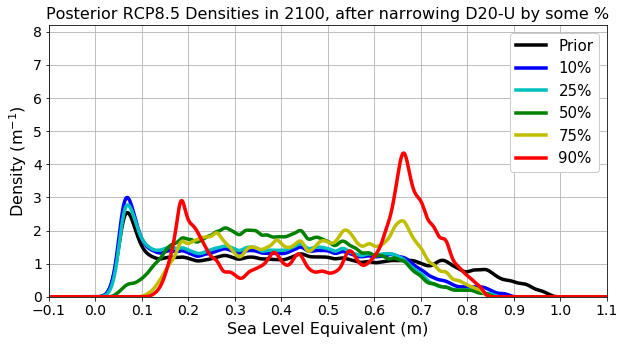

In [44]:
compare_dists3=plt.figure(figsize=(10,5))
plt.plot(dat_in['step_locs_2100'],prior_kde(dat_in['step_locs_2100']),color='k',lw=3.5,label='Prior')
plt.plot(dat_in['step_locs_2100'],range10_kde(dat_in['step_locs_2100']),color='b',lw=3.5,label='10%')
plt.plot(dat_in['step_locs_2100'],range25_kde(dat_in['step_locs_2100']),color='c',lw=3.5,label='25%')
plt.plot(dat_in['step_locs_2100'],range50_kde(dat_in['step_locs_2100']),color='g',lw=3.5,label='50%')
plt.plot(dat_in['step_locs_2100'],range75_kde(dat_in['step_locs_2100']),color='y',lw=3.5,label='75%')
plt.plot(dat_in['step_locs_2100'],range90_kde(dat_in['step_locs_2100']),color='r',lw=3.5,label='90%')
plt.xlim([-0.1,1.1])
plt.title('Posterior RCP8.5 Densities in 2100, after narrowing D20-U by some %',fontsize=16)
plt.ylabel('Density (m$^{-1}$)',fontsize=16)
plt.xlabel('Sea Level Equivalent (m)',fontsize=16)
plt.xticks(np.linspace(-0.1,1.1,13),fontsize=14)
plt.yticks(np.linspace(0,9,10),fontsize=14)
plt.xlim([-0.1,1.1])
plt.ylim([0,8.2])
plt.legend(loc='best',fontsize=15,framealpha=1.0)
plt.grid()
plt.show()

In [45]:
compare_dists3.savefig("figures/FigS10.pdf")